In [ ]:
# this variable will be used in `runner.train` and by default we disable FP16 mode
is_fp16_used = False

### Instalations

In [168]:
# Catalyst
!pip install catalyst

# for augmentations
!pip install albumentations

# for pretrained segmentation models for PyTorch
#!pip install segmentation-models-pytorch==0.1.0

# for TTA
!pip install ttach

     |████████████████████████████████| 446 kB 753 kB/s eta 0:00:01
     |████████████████████████████████| 125 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 123 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 116 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 48.3 MB 1.7 MB/s eta 0:00:01    |███▌                            | 5.3 MB 911 kB/s eta 0:00:48


# Virtual kitti dataloader

In [1]:
import os
import torch
import shutil
import numpy as np
import pandas as pd

from PIL import Image

In [2]:
import matplotlib.pyplot as plt

In [3]:
from typing import List

from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [4]:

class SingleImageVirtualKittiDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        root: str, 
        mode: str = "train", 
        transforms = None):

        assert mode in {"train", "valid", "test"}

        self.mode = mode
        self.transforms = transforms

        self.files_directory = root
  
        self.scene_folder_name = ['Scene01','Scene02','Scene06','Scene18','Scene20']
        self.scenario_folder_name = ['15-deg-left','15-deg-right','30-deg-left',
                                 '30-deg-right','clone','fog','morning',
                                 'overcast','rain','sunset']
        self.data_folder_name = ['classSegmentation','rgb']
        self.file_prefix_name = ['classgt', 'rgb']
        self.file_format_name = ['png', 'jpg']
        self.output_name = ['mask', 'image']
        self.camera_folder_name = ['Camera_0', 'Camera_1']
        self.data_column_names=['scene', 'scenario', 'camera_number', 'frame_number']
        
        #Filenames extracted as a pandas dataframe
        self.filenames = self._read_split()  # read train/valid/test splits
        self.mask_colors = pd.read_csv(os.path.join(self.files_directory, 
                                               self.scene_folder_name[0], 
                                               self.scenario_folder_name[0],
                                               'colors.txt'), 
                                       delimiter=' ')
        self.mask_colors['mask_label'] = self.mask_colors.index
        #Replacing the follwing
        #[GuardRail, TrafficLight, Pole, Truck, Van, Undefined] -> 
        #[Misc,      TrafficSign,  Misc, Car,   Car, Misc]
        self.mask_colors['mask_label'] =self.mask_colors['mask_label'].replace([6, 9, 10, 14, 7, 8, 11, 12, 13], 
                                                                    [8, 8, 8, 8, 6, 6, 7, 7, 7])
        print ("Total classes ", len(self.mask_colors['mask_label'].unique()))
        print ("Total classes ", (self.mask_colors['mask_label'].unique()))
        #Final classes are
        self.mask_colors = self.mask_colors.values.tolist()
      
    def __len__(self) -> int:
        return len(self.filenames)
    def __getitem__(self, idx: int) -> dict:

        scene, scenario, camera, frame_number = self.filenames[idx]
        sample = {}
        for folder, prefix, file_format, output in zip(self.data_folder_name, 
                                               self.file_prefix_name,
                                               self.file_format_name,
                                               self.output_name):
            frame_name = prefix+'_'+frame_number+'.'+file_format
            image_path = os.path.join(self.files_directory, scene, scenario, 'frames', folder, camera, frame_name)
            sample[output] = np.array(Image.open(image_path))
           

        sample['mask'] = self._preprocess_mask(sample['mask'])

        # convert to other format HWC -> CHW
        #sample["image"] = np.moveaxis(sample["image"], -1, 0)
        #sample["mask"] = np.expand_dims(sample["mask"], 0)
        
        
        #Applies transformation and converts to tensor
        if self.transforms is not None:            
            transformed = self.transforms(image=sample['image'], mask=sample['mask'])

            sample['image'] = transformed['image']
            sample['mask'] = transformed['mask'].long()
        

        return sample
    
    def _preprocess_mask(self, mask: np.ndarray) -> np.ndarray:
        ''' 
        Convert RGB mask to single channel mask based on the color value
        provided in color.txt file 
        
        Parameters:
            mask: Numpy array mask of shape [height, width, 3]
            out: Numpy array of shape [height, width]
        '''
        preprocessed_mask = np.zeros(mask.shape[:2])
        for index, row in enumerate(self.mask_colors):
            # Each array of mask color  ['Terrain', r, g, b, mask_label]
            idx = np.all(mask == (row[1], row[2], row[3]), axis=-1) #
            preprocessed_mask[idx] = row[4]

        return preprocessed_mask

    def _read_split(self) -> list:
        ''' 
        Parses the virual kitti dataset and converts to a pandas dataframe
        
        Parameters:
            out: A list
        '''
        filenames = []
        for scene in self.scene_folder_name:
            for scenario in self.scenario_folder_name:
                #extrinsic = pd.read_csv(os.path.join(self.files_directory, scene, scenario,'extrinsic.txt'),
                #                        delimiter=' ')
                for camera in self.camera_folder_name:
                    single_filenames = os.listdir(os.path.join(self.files_directory, 
                                                               scene, 
                                                               scenario, 
                                                               'frames', 
                                                               'rgb', 
                                                               camera))
                    single_filenames.sort()
                    for f in single_filenames:
                        #Splitting filename rgb_0000.jpg first replacing '.' with '_'
                        _, frame_number, _ = f.replace('.','_').split('_') 
                        _, camera_number = camera.split('_')
                        #Loc is a slow query 

                        filenames.append([scene, scenario, camera, frame_number])

        filenames = pd.DataFrame(filenames, columns=self.data_column_names)
        

 

        if self.mode == "train":  # 90% for train
            # Creating a dataframe with 50%
            filenames = filenames.sample(frac = 0.9, random_state=55)
        elif self.mode == "valid":  # 10% for validation
            #sampling the same files with the random_state and droping them
            train_filenames = filenames.sample(frac = 0.9, random_state=55)
            filenames = filenames.drop(train_filenames.index)
            
        return filenames.values.tolist()



## Setting up GPU 

In [5]:
from typing import Callable, List, Tuple

import os
import torch
import catalyst
from catalyst import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

torch: 1.10.2, catalyst: 22.04


## Albumentation Transforms

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def pre_transforms(image_size=224):
    return [A.Resize(image_size, image_size, p=1)]


def hard_transforms():
    result = [
      A.CoarseDropout(),
      A.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
      ),
      A.GridDistortion(p=0.3),
      A.HueSaturationValue(p=0.3)
    ]

    return result
  

def resize_transforms(image_size=224):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      A.SmallestMaxSize(pre_size, p=1),
      A.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    rescale = albu.Compose([A.Resize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose([
      A.LongestMaxSize(pre_size, p=1),
      A.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    # Converts the image to a square of size image_size x image_size
    result = [
      A.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [A.Normalize(), ToTensorV2()]
  
def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = A.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [7]:
train_transforms = compose([
    #resize_transforms(),  #There seems to be error in finding the proper crop size
    pre_transforms(),
    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])



## Training 


In [8]:
import segmentation_models_pytorch as smp

# We will use Feature Pyramid Network with pre-trained ResNeXt50 backbone
model = smp.FPN(encoder_name="timm-mobilenetv3_small_minimal_100", classes=9)

In [10]:
x = torch.rand(2, 3, 224, 224)
model(x).shape

torch.Size([2, 9, 224, 224])

In [17]:
# Example of target with class indices
loss = torch.nn.CrossEntropyLoss()

# Example of target with class probabilities
input = torch.randn(2, 3, 5, 5, requires_grad=True)
target = torch.randint(2, 5, 5).long()
output = loss(input, target)


IndexError: Target -1 is out of bounds.

We will optimize loss as the sum of IoU, Dice and BCE, specifically this function: $IoU + Dice + 0.8*BCE$.\n .

In [14]:
from torch import nn

from catalyst.contrib.losses import DiceLoss, IoULoss
import catalyst.dl as dl
from functools import partial

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "ce": nn.CrossEntropyLoss()
}

callbacks = [
    
    dl.BatchTransformCallback(
        scope="on_batch_end",
        transform="torch.relu",
        input_key="logits",
        output_key="scores",
    ),
    dl.BatchTransformCallback(
        input_key="scores",
        output_key="pred_mask",
        transform=partial(torch.argmax, dim=1),
        scope="on_batch_end",
    ),
    dl.CriterionCallback(
        "pred_mask", "mask", "loss_dice", criterion_key="dice"
    ),
    dl.CriterionCallback("pred_mask", "mask", "loss_iou", criterion_key="iou"),
    dl.CriterionCallback("scores", "mask", "loss_ce", criterion_key="ce"),
    dl.MetricAggregationCallback(
        "loss",
        mode="weighted_sum",
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_ce": 0.8},
    ),
    dl.DiceCallback("pred_mask", "mask"),
    dl.IOUCallback("pred_mask", "mask"),
]

In [10]:
from torch import optim

from catalyst.contrib.optimizers import RAdam, Lookahead

learning_rate = 0.001
encoder_learning_rate = 0.0005

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
#layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
#model_params = utils.torch.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model.parameters(), lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)

In [11]:
from catalyst.dl import SupervisedRunner

num_epochs = 3
logdir = "./logs/segmentation"

device = utils.get_device()
print(f"device: {device}")




# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
#runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")
runner = SupervisedRunner(
    input_key="image", output_key="logits", target_key="mask"
)

device: cuda


In [12]:
%%time
root = '/home/deebuls/Documents/phd/dataset/virtual_kitti/'

valid_dataset = SingleImageVirtualKittiDataset(root, "valid", transforms=valid_transforms)

train_dataset = SingleImageVirtualKittiDataset(root, "train", transforms=train_transforms)

loaders = {
    "train": DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=int(16/2)), 
    "valid": DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=int(16/2)),
}


Total classes  9
Total classes  [ 0  1  2  3  4  5 10  7 12]
Total classes  9
Total classes  [ 0  1  2  3  4  5 10  7 12]
CPU times: user 204 ms, sys: 24.5 ms, total: 228 ms
Wall time: 227 ms


In [13]:
from catalyst import dl
from catalyst.contrib.losses import IoULoss

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=1,
    callbacks=callbacks,
    logdir="./lightning_logs",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
)

1/1 * Epoch (train):   0%|          | 0/2392 [00:00<?, ?it/s]

/opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:95: nll_loss2d_forward_kernel: block: [4,0,0], thread: [828,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:95: nll_loss2d_forward_kernel: block: [4,0,0], thread: [28,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:95: nll_loss2d_forward_kernel: block: [4,0,0], thread: [764,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:95: nll_loss2d_forward_kernel: block: [4,0,0], thread: [765,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:95: nll_loss2d_forward_kernel: block: [4,0,0], thread: [988,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

## Dataloader 

In [27]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    #dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image = dataset[idx]
        ax[i, 0].imshow(image['image'].permute(1,2,0))
        ax[i, 1].imshow(image['mask'], interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()


In [36]:
%%time
root = '/home/deebuls/Documents/phd/dataset/virtual_kitti/'

valid_dataset = SingleImageVirtualKittiDataset(root, "valid", transforms=valid_transforms)
#valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=int(16/2))


Total classes  9
Total classes  [ 0  1  2  3  4  5 10  7 12]
CPU times: user 28.3 ms, sys: 20.2 ms, total: 48.5 ms
Wall time: 47.8 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


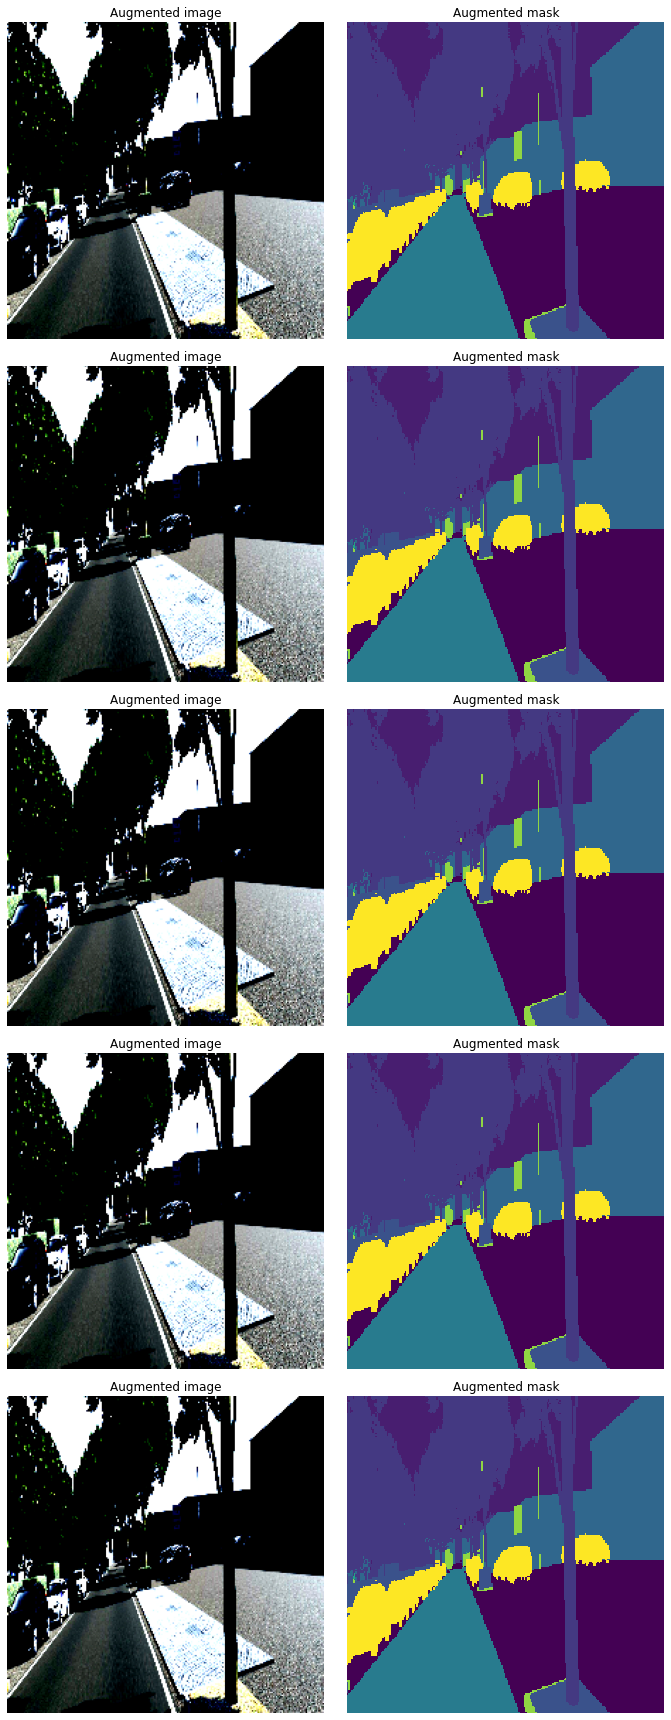

In [29]:
import random
import copy 
random.seed(2)
visualize_augmentations(valid_dataset, idx=89)



## Pixel anaylis 

In [184]:
%%time
root = '/home/deebuls/Documents/phd/dataset/virtual_kitti/'

valid_dataset = SingleImageVirtualKittiDataset(root, "valid", transforms=valid_transforms)

train_dataset = SingleImageVirtualKittiDataset(root, "train", transforms=train_transforms)

loaders = {
    "train": DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=int(16/2)), 
    "valid": DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=int(16/2)),
}


Total classes  9
        Category    r    g    b  mask_label
0        Terrain  210    0  200           0
1            Sky   90  200  255           1
2           Tree    0  199    0           2
3     Vegetation   90  240    0           3
4       Building  140  140  140           4
5           Road  100   60  100           5
6      GuardRail  250  100  255          10
7    TrafficSign  255  255    0           7
8   TrafficLight  200  200    0           7
9           Pole  255  130    0          10
10          Misc   80   80   80          10
11         Truck  160   60   60          12
12           Car  255  127   80          12
13           Van    0  139  139          12
14     Undefined    0    0    0          10
Total classes  9
        Category    r    g    b  mask_label
0        Terrain  210    0  200           0
1            Sky   90  200  255           1
2           Tree    0  199    0           2
3     Vegetation   90  240    0           3
4       Building  140  140  140           

In [151]:
print (" Training dataset length ", len(train_dataset))
print (" valid_dataset  length ", len(valid_dataset))

 Training dataset length  38268
 valid_dataset  length  4252


In [33]:
from collections import Counter


In [34]:
%%time
max_count = {}
for idx, sample in enumerate(valid_dataset):
    #print (sample['mask'].unique(return_counts=True))
    mask_values, count = sample['mask'].unique(return_counts=True)
    zip_count = dict(zip(mask_values.tolist(), count.tolist()))
    #max_count = dict(list(max_count.items()) + list(zip_count.items()))
    max_count = dict(Counter(max_count)+ 
                     Counter(zip_count))

    if idx == 0: continue
    if idx % 5==0: break
    
max_count

CPU times: user 360 ms, sys: 0 ns, total: 360 ms
Wall time: 323 ms


{0: 9778,
 1: 5371,
 2: 25675,
 3: 4135,
 4: 19291,
 5: 17495,
 7: 4,
 10: 3410,
 12: 15193}

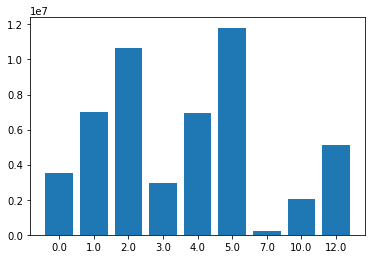

In [186]:
import matplotlib.pyplot as plt

names = list(max_count.keys())
values = list(max_count.values())

plt.bar(range(len(max_count)), values, tick_label=names)
plt.show()

In [165]:
%%time
max_count = {}
for idx, sample in enumerate(train_dataset):
    #print (sample['mask'].unique(return_counts=True))
    mask_values, count = sample['mask'].unique(return_counts=True)
    zip_count = dict(zip(mask_values.tolist(), count.tolist()))
    #max_count = dict(list(max_count.items()) + list(zip_count.items()))
    max_count = dict(Counter(max_count)+ 
                     Counter(zip_count))

    if idx == 0: continue
    if idx % 1000==0: break
    
max_count

KeyboardInterrupt: 

Function preperocess  Took 0.1393 seconds

## Test code

In [ ]:

class SingleImageVirtualKittiDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        root: str, 
        mode: str = "train", 
        transforms = None):

        assert mode in {"train", "valid", "test"}

        self.mode = mode
        self.transforms = transforms

        self.files_directory = root
  
        self.scene_folder_name = ['Scene01','Scene02','Scene06','Scene18','Scene20']
        self.scenario_folder_name = ['15-deg-left','15-deg-right','30-deg-left',
                                 '30-deg-right','clone','fog','morning',
                                 'overcast','rain','sunset']
        self.data_folder_name = ['classSegmentation','depth','rgb']
        self.file_prefix_name = ['classgt', 'depth', 'rgb']
        self.file_format_name = ['png', 'png', 'jpg']
        self.output_name = ['mask', 'depth', 'image']
        self.camera_folder_name = ['Camera_0', 'Camera_1']
        self.extrinsic_row_names = ['r1,1', 'r1,2', 'r1,3', 't1', 'r2,1', 'r2,2',
               'r2,3', 't2', 'r3,1', 'r3,2', 'r3,3', 't3', '0', '0.1', '0.2', '1']
        self.data_column_names=['scene', 'scenario', 'camera_number', 'frame_number', 'extrinsic']
        
        #Filenames extracted as a pandas dataframe
        self.filenames = self._read_split()  # read train/valid/test splits
        self.mask_colors = pd.read_csv(os.path.join(self.files_directory, 
                                               self.scene_folder_name[0], 
                                               self.scenario_folder_name[0],
                                               'colors.txt'), 
                                       delimiter=' ')
      
      
    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(self, idx: int) -> dict:

        scene, scenario, camera, frame_number = self.filenames.iloc[idx]
        sample = {}
        for folder, prefix, file_format, output in zip(self.data_folder_name, 
                                               self.file_prefix_name,
                                               self.file_format_name,
                                               self.output_name):
            frame_name = prefix+'_'+frame_number+'.'+file_format
            image_path = os.path.join(self.files_directory, scene, scenario, 'frames', folder, camera, frame_name)
            sample[output] = np.array(Image.open(image_path))
           

        sample['mask'] = self._preprocess_mask(sample['mask'])

        # convert to other format HWC -> CHW
        #sample["image"] = np.moveaxis(sample["image"], -1, 0)
        #sample["mask"] = np.expand_dims(sample["mask"], 0)
        
        
        #Applies transformation and converts to tensor
        if self.transforms is not None:            
            transformed = self.transforms(image=sample['image'], 
                                          masks=[sample['mask'], sample['depth']])

            sample['image'] = transformed['image']
            sample['mask'] = transformed['masks'][0]
            sample['depth'] = transformed['masks'][1]
        

        return sample

    def _preprocess_mask(self, mask: np.ndarray) -> np.ndarray:
        ''' 
        Convert RGB mask to single channel mask based on the color value
        provided in color.txt file 
        
        Parameters:
            mask: Numpy array mask of shape [height, width, 3]
            out: Numpy array of shape [height, width]
        '''
        preprocessed_mask = np.zeros(mask.shape[:2])
        for index, row in self.mask_colors.iterrows():
            idx = np.all(mask == (row['r'], row['g'], row['b']), axis=-1)
            preprocessed_mask[idx] = index

        return preprocessed_mask

    def _read_split(self):
        ''' 
        Parses the virual kitti dataset and converts to a pandas dataframe
        
        Parameters:
            out: A Pandas Dataframe
        '''
        filenames = []
        for scene in self.scene_folder_name:
            for scenario in self.scenario_folder_name:
                extrinsic = pd.read_csv(os.path.join(self.files_directory, scene, scenario,'extrinsic.txt'),
                                        delimiter=' ')
                for camera in self.camera_folder_name:
                    single_filenames = os.listdir(os.path.join(self.files_directory, 
                                                               scene, 
                                                               scenario, 
                                                               'frames', 
                                                               'rgb', 
                                                               camera))
                    single_filenames.sort()
                    for f in single_filenames:
                        #Splitting filename rgb_0000.jpg first replacing '.' with '_'
                        _, frame_number, _ = f.replace('.','_').split('_') 
                        _, camera_number = camera.split('_')
                        #Loc is a slow query 
                        x = extrinsic.loc[(extrinsic['frame'] == int(frame_number)) & \
                                          (extrinsic['cameraID'] == int(camera_number)), 
                                          self.extrinsic_row_names].values.flatten().tolist()
                        filenames.append([scene, scenario, camera, frame_number, x])

        filenames = pd.DataFrame(filenames, columns=self.data_column_names)
        

 

        if self.mode == "train":  # 90% for train
            # Creating a dataframe with 50%
            filenames = filenames.sample(frac = 0.9, random_state=55)
        elif self.mode == "valid":  # 10% for validation
            #sampling the same files with the random_state and droping them
            train_filenames = filenames.sample(frac = 0.9, random_state=55)
            filenames = filenames.drop(train_filenames.index)
            
        return filenames



In [93]:
files_directory = '/home/deebuls/Documents/phd/dataset/virtual_kitti'
scene_folder_name = ['Scene01','Scene02','Scene06','Scene18','Scene20']
scenario_folder_name = ['15-deg-left','15-deg-right','30-deg-left',
                         '30-deg-right','clone','fog','morning',
                         'overcast','rain','sunset']
data_folder_name = ['classSegmentation','depth','rgb']
file_prefix_name = ['classgt', 'depth', 'rgb']
file_format_name = ['png', 'png', 'jpg']
camera_folder_name = ['Camera_0', 'Camera_1']
extrinsic_row_names = ['r1,1', 'r1,2', 'r1,3', 't1', 'r2,1', 'r2,2',
       'r2,3', 't2', 'r3,1', 'r3,2', 'r3,3', 't3', '0', '0.1', '0.2', '1']

In [94]:
%%time
filenames = []
for scene in scene_folder_name:
    for scenario in scenario_folder_name:
        extrinsic = pd.read_csv(os.path.join(files_directory, scene, scenario,'extrinsic.txt'), delimiter=' ')
        for camera in camera_folder_name:
            single_filenames = os.listdir(os.path.join(files_directory, scene, scenario, 'frames', 'rgb', camera))
            single_filenames.sort()
            for f in single_filenames:
                #Splitting filename rgb_0000.jpg first replacing '.' with '_'
                _, frame_number, _ = f.replace('.','_').split('_') 
                _, camera_number = camera.split('_')
                #Loc is a slow query 
                x = extrinsic.loc[(extrinsic['frame'] == int(frame_number)) & \
                                  (extrinsic['cameraID'] == int(camera_number)), 
                                  extrinsic_row_names].values.flatten().tolist()
                filenames.append([scene, scenario, camera, frame_number, x])
                
filenames = pd.DataFrame(filenames, columns=['scene', 'scenario', 'camera_number', 'frame_number', 'extrinsic'])

CPU times: user 23.6 s, sys: 35.9 ms, total: 23.6 s
Wall time: 23.7 s


In [168]:
f = filenames.values.tolist()
f[0]

['Scene01',
 '15-deg-left',
 'Camera_0',
 '00000',
 [-0.008019686,
  0.07217909,
  -0.9973595,
  7.494453,
  -0.0009896867,
  0.9973904,
  0.0721893,
  112.4036,
  0.9999674,
  0.001566,
  -0.007927299,
  -0.7717823,
  0.0,
  0.0,
  0.0,
  1.0]]

In [169]:
mask_colors = pd.read_csv(os.path.join(files_directory, scene, scenario,'colors.txt'), delimiter=' ')
mask_colors

,Category,r,g,b
0,Terrain,210,0,200
1,Sky,90,200,255
2,Tree,0,199,0
3,Vegetation,90,240,0
4,Building,140,140,140
5,Road,100,60,100
6,GuardRail,250,100,255
7,TrafficSign,255,255,0
8,TrafficLight,200,200,0
9,Pole,255,130,0


In [176]:
mask_colors['mask'] = mask_colors.index
mask_colors['mask'] = mask_colors['mask'].replace([6, 8, 9, 11, 13, 14], [10, 7, 10, 12, 12, 10])
mask_colors

,Category,r,g,b,mask
0,Terrain,210,0,200,0
1,Sky,90,200,255,1
2,Tree,0,199,0,2
3,Vegetation,90,240,0,3
4,Building,140,140,140,4
5,Road,100,60,100,5
6,GuardRail,250,100,255,10
7,TrafficSign,255,255,0,7
8,TrafficLight,200,200,0,7
9,Pole,255,130,0,10


In [129]:
mask_colors.values.tolist()


[['Terrain', 210, 0, 200],
 ['Sky', 90, 200, 255],
 ['Tree', 0, 199, 0],
 ['Vegetation', 90, 240, 0],
 ['Building', 140, 140, 140],
 ['Road', 100, 60, 100],
 ['GuardRail', 250, 100, 255],
 ['TrafficSign', 255, 255, 0],
 ['TrafficLight', 200, 200, 0],
 ['Pole', 255, 130, 0],
 ['Misc', 80, 80, 80],
 ['Truck', 160, 60, 60],
 ['Car', 255, 127, 80],
 ['Van', 0, 139, 139],
 ['Undefined', 0, 0, 0]]

In [130]:
l = [['Terrain', 210, 0, 200],
 ['Sky', 90, 200, 255],
 ['Tree', 0, 199, 0],
 ['Vegetation', 90, 240, 0],
 ['Building', 140, 140, 140],
 ['Road', 100, 60, 100],
 ['GuardRail', 250, 100, 255],
 ['TrafficSign', 255, 255, 0],
 ['TrafficLight', 200, 200, 0],
 ['Pole', 255, 130, 0],
 ['Misc', 80, 80, 80],
 ['Truck', 160, 60, 60],
 ['Car', 255, 127, 80],
 ['Van', 0, 139, 139],
 ['Undefined', 0, 0, 0]]

In [167]:
def get_item(idx):
    print (filenames.iloc[0])
    scene, scenario, camera, frame_number, x = filenames.iloc[0]
    image = {}
    for folder, prefix, file_format in zip(data_folder_name, 
                                             file_prefix_name,
                                             file_format_name):
        frame_name = prefix+'_'+frame_number+'.'+file_format
        print (os.path.join(files_directory, scene, scenario, 'frames', folder, camera, frame_name))
        image_path = os.path.join(files_directory, scene, scenario, 'frames', folder, camera, frame_name)
        if (folder=='rgb'):
            #image['rgb'] = np.array(Image.open(image_path).convert("RGB"))
            image['rgb'] = np.array(Image.open(image_path))
            print ('RGB shape', image['rgb'].shape)
        else:
            image[folder] = np.array(Image.open(image_path))
            print (' shape', folder , image[folder].shape)
            
    return image
        
i = get_item(0)

scene                                                      Scene01
scenario                                               15-deg-left
camera_number                                             Camera_0
frame_number                                                 00000
extrinsic        [-0.008019686, 0.07217909, -0.9973595, 7.49445...
Name: 0, dtype: object
/home/deebuls/Documents/phd/dataset/virtual_kitti/Scene01/15-deg-left/frames/classSegmentation/Camera_0/classgt_00000.png
 shape classSegmentation (375, 1242, 3)
/home/deebuls/Documents/phd/dataset/virtual_kitti/Scene01/15-deg-left/frames/depth/Camera_0/depth_00000.png
 shape depth (375, 1242)
/home/deebuls/Documents/phd/dataset/virtual_kitti/Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg
RGB shape (375, 1242, 3)


In [282]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GridDistortion(p=0.5),    
    A.RandomCrop(height=255, width=255, p=0.5),    
], p=1)

transformed = transform(image=i['rgb'], masks=[i['classSegmentation'], i['depth']])

image_transformed = transformed['image']
mask_transformed = transformed['masks'][0]
mask2_transformed = transformed['masks'][1]

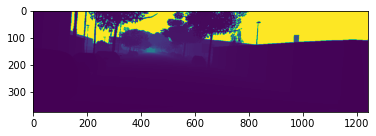

In [283]:
plt.imshow(mask2_transformed)

In [248]:
## Difeerence between differnt reads

from skimage.io import imread as gif_imread
from catalyst.contrib.utils.image import imread
 
image = imread('/home/deebuls/Documents/phd/dataset/virtual_kitti/Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg')
mask = gif_imread('/home/deebuls/Documents/phd/dataset/virtual_kitti/Scene01/15-deg-left/frames/classSegmentation/Camera_0/classgt_00000.png')

print (image.shape, mask.shape)

(375, 1242, 3) (375, 1242, 3)


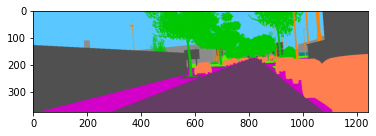

In [250]:
plt.imshow(mask)

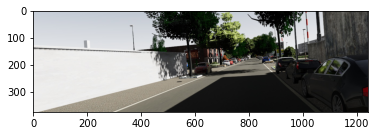

In [249]:
plt.imshow(image)

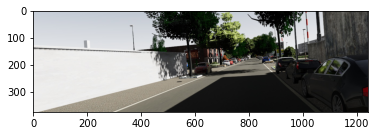

In [227]:
plt.imshow(i['rgb'])

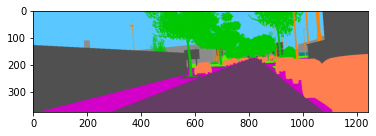

In [129]:
plt.imshow(i['classSegmentation'])

In [146]:
i['classSegmentation'].shape[:2]

(375, 1242)

In [156]:
idx = i['classSegmentation'] == [row['r'], row['g'], row['b']]
idx[:,:,0].shape

(375, 1242)

In [158]:
j = np.zeros(i['classSegmentation'].shape[:2])
for index, row in mask_colors.iterrows():
    print (index)
    idx = i['classSegmentation'] == [row['r'], row['g'], row['b']]
    j[idx[:,:,0]] = index
print (np.unique(j))

0
(30194,)
1
(92766,)
2
(62720,)
3
(92766,)
4
(9143,)
5
(80202,)
6
(0,)
7
(60978,)
8
(0,)
9
(60978,)
10
(129745,)
11
(2,)
12
(60978,)
13
(62720,)
14
(62720,)
[ 0.  3.  4.  5. 10. 11. 12. 14.]


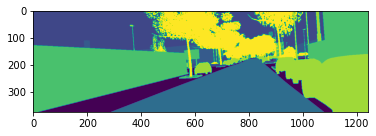

In [159]:
plt.imshow(j)

In [ ]:
def rgb_to_mask(img, id2code):
    posterior = map(self.single_row_calculation, 
                    prior, 
                    current)

In [ ]:

def rgb_to_mask(img, id2code):
    ''' 
        Converts a RGB image mask of shape [batch_size,h, w, color_code], to a mask of shape
        [batch_size,n_classes,h,w]
        
        Parameters:
            img: A RGB img mask
            color_map: Dictionary representing color mappings: ecah class assigns to a unique color code
        returns:
            out: A Binary Mask of shape [batch_size, classes, h, w]
    '''
    
    # num_classes is equal to len(mask) 
    num_classes = len(id2code)
    
    # it makes a tensor of shape h,w,num_classes:(720,960,num_classes)
    shape = img.shape[:2]+(num_classes,)
    
    # it makes a tensor with given shape and with type float64
    out = np.zeros(shape, dtype=np.float64)
    
    # 
    for i, cls in enumerate(id2code):
        
        #print(f'i: {i}, cls: {cls}')
        
        # img.reshape((-1,3)) flats mask except in channels
        
        # it reads thecolor code for a multiplication of higght and width and if it is one of the color code of 
        # the classes that we have then the third dimension takes the label of that class and the first
        # two dimsnions return to the hight and width  
        out[:,:,i] = np.all(np.array(img).reshape((-1,3)) == id2code[i], axis=1).reshape(shape[:2])
        
        # out: hight, width, class
        # returns class, hight, width
    return(out.transpose(2,0,1))

In [48]:
mask_path = '/home/deebuls/Documents/phd/dataset/virtual_kitti/Scene01/15-deg-left/frames/classSegmentation/Camera_0/classgt_00000.png'

In [52]:
mask = np.array(Image.open(mask_path))
print (mask.shape)
np.unique(mask.reshape(-1, 3), axis=0, return_counts=True)

(375, 1242, 3)


(array([[  0, 139, 139],
        [  0, 199,   0],
        [ 80,  80,  80],
        [ 90, 200, 255],
        [ 90, 240,   0],
        [100,  60, 100],
        [140, 140, 140],
        [160,  60,  60],
        [210,   0, 200],
        [255, 127,  80],
        [255, 130,   0],
        [255, 255,   0]], dtype=uint8),
 array([   397,  62323, 129745,  90789,   1977,  80202,   9143,      2,
         30194,  56273,   4700,      5]))

In [76]:
j = np.zeros(mask.shape[:2])
for index, row in mask_colors.iterrows():
    print (index, row.to_list())
    idx = np.all(mask == (row['r'], row['g'], row['b']), axis=-1)
    print (np.count_nonzero(idx))
    j[idx] = index
print (np.unique(j, return_counts=True))

0 ['Terrain', 210, 0, 200]
30194
1 ['Sky', 90, 200, 255]
90789
2 ['Tree', 0, 199, 0]
62323
3 ['Vegetation', 90, 240, 0]
1977
4 ['Building', 140, 140, 140]
9143
5 ['Road', 100, 60, 100]
80202
6 ['GuardRail', 250, 100, 255]
0
7 ['TrafficSign', 255, 255, 0]
5
8 ['TrafficLight', 200, 200, 0]
0
9 ['Pole', 255, 130, 0]
4700
10 ['Misc', 80, 80, 80]
129745
11 ['Truck', 160, 60, 60]
2
12 ['Car', 255, 127, 80]
56273
13 ['Van', 0, 139, 139]
397
14 ['Undefined', 0, 0, 0]
0
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  7.,  9., 10., 11., 12., 13.]), array([ 30194,  90789,  62323,   1977,   9143,  80202,      5,   4700,
       129745,      2,  56273,    397]))


In [71]:
_, count = np.unique(mask.reshape(-1, 3), axis=0, return_counts=True)
np.sum(count)

465750

In [72]:
375*1242

465750

In [75]:
idx = np.all(mask == (0, 139, 139), axis=-1)
np.count_nonzero(idx)

397

In [69]:
np.count_nonzero( mask.reshape(-1, 3) == [0, 139, 139])

63514